## Aprendizaje Profundo: Tarea 1 - Ejercicio 3
### Samuel López Ruiz
---
Modelo de regresión lineal para el conjunto de datos de calificaciones

Importación de liberías y definición dediccionario con 3 funciones de activación comunes

In [1]:
import math
import os
import random

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from itertools import islice as take
import time
from sklearn.preprocessing import StandardScaler
import copy

activations = {'relu': nn.ReLU(), 'sigmoid': nn.Sigmoid(), 'tanh': nn.Tanh()}


Función para cargar y graficar los datos.

In [2]:
def load_dataset():
    if 'data' not in os.listdir('.'):
        os.mkdir('./data')
    if 'califs.csv' not in os.listdir('./data'):
        URL = 'https://raw.githubusercontent.com/gibranfp/CursoAprendizajeProfundo/2022-1/data/califs.csv'
        df = pd.read_csv(URL)
        df.to_csv('data/califs.csv')

    return pd.read_csv('data/califs.csv', header=0, index_col=0)


def plot_3d(df):
    cols = df.columns
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.scatter(df[cols[0]], df[cols[1]], df[cols[2]])
    ax.set_xlabel(cols[0], fontsize=10)
    ax.set_ylabel(cols[1], fontsize=10)
    ax.set_zlabel(cols[2], fontsize=10)
    plt.show()

Definición de bajo nivel de una capa lineal, así como las definición de medio nivel de toda la red.

In [3]:
class MyLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        # se envuelven los tensores en parámetros (clase)
        # para que model.parameters() los regrese
        # y sean visibles al optimizador
        self.weight = nn.Parameter(torch.zeros(out_features, in_features))
        self.bias = nn.Parameter(torch.zeros(out_features))
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
        bound = 1 / math.sqrt(fan_in)
        nn.init.uniform_(self.bias, -bound, bound)

    def forward(self, x):
        # X * W + B
        return F.linear(x, self.weight, self.bias)

    def extra_repr(self):
        return 'in_features={}, out_features={}, init={}, bias={}'.format(
            self.in_features, self.out_features, self.init, self.bias is not None
        )


class Net(nn.Module):
    def __init__(self, n_inputs, n_hidden_layers, n_nodes, activation='relu'):
        super(Net, self).__init__()
        self.activation = activation
        self.in_layer = MyLinear(in_features=n_inputs, out_features=n_nodes)
        self.fcs = [nn.Linear(in_features=n_nodes, out_features=n_nodes) for i in range(n_hidden_layers - 1)]
        self.out_layer = nn.Linear(in_features=n_nodes, out_features=1)

    def forward(self, x):
        # logits = self.linear_stack(x)
        x = self.in_layer(x)
        for layer in self.fcs:
            x = activations[self.activation](layer(x))
        x = self.out_layer(x)
        return x


class CustomCalifDataset(Dataset):
    def __init__(self, df):
        self.labels = df['calif'].to_numpy().reshape(-1, 1)
        self.x = df[['prev', 'horas']].to_numpy()

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # sample = {"x": self.x[idx], "labels": self.labels[idx]}
        sample = (self.x[idx], self.labels[idx])
        return sample

Funciones arnés para entrenar y evaluar un modelo de pytorch.

In [4]:
def train_epoch(dl, model, optimizer, criterion):
    # por cada lote
    for inputs, labels in dl:
        # computamos logits
        outputs = model(inputs)

        # computamos la pérdida
        loss = criterion(outputs, labels)

        # vaciamos los gradientes
        optimizer.zero_grad()

        # retropropagamos
        loss.backward()

        # actualizamos parámetros
        optimizer.step()


def eval_epoch(dl, model, criterion, num_batches=None):
    # evitamos que se registren las operaciones
    # en la gráfica de cómputo
    with torch.no_grad():
        # historiales
        losses = []

        # validación de la época con num_batches
        # si num_batches==None, se usan todos los lotes
        for inputs, labels in take(dl, num_batches):
            # computamos los logits
            outputs = model(inputs)

            # computamos la pérdida
            loss = criterion(outputs, labels)

            # guardamos históricos
            losses.append(loss.item())

        # promediamos
        loss = np.mean(losses)

        return loss


def train(model, optimizer, trn_dl, tst_dl, criterion, epochs=20,
          trn_batches=None, tst_batches=None, verbose=1):
    # historiales
    loss_hist = []

    # ciclo de entrenamiento
    for epoch in range(epochs):
        # entrenamos la época
        train_epoch(trn_dl, model, optimizer, criterion)

        # evaluamos la época en entrenamiento
        trn_loss = eval_epoch(trn_dl, model, criterion, trn_batches)
        # evaluamos la época en prueba
        tst_loss = eval_epoch(tst_dl, model, criterion, tst_batches)

        # guardamos historial
        loss_hist.append([trn_loss, tst_loss])

        # imprimimos progreso
        if verbose > 0:
            print(f' E{epoch:02} '
                  f'loss=[{trn_loss:6.2f},{tst_loss:6.2f}] ')

    return np.array(loss_hist)


Funciones para graficar la pérdida a lo largo de las épocas asi como
la pérdida usando varias configuraciones de los modelos (grid search).

In [5]:
def plot_loss_hist(loss_hist):
    fig, ax = plt.subplots()
    ax.plot(loss_hist[:, 0], label='Train Loss')
    ax.plot(loss_hist[:, 1], label='Test Loss')
    plt.legend()
    plt.xlabel('epoch')
    plt.xlabel('loss')
    plt.show()

def plot_gs(var_range, grid_loss, var_name):
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(var_range, grid_loss, label='loss')
    plt.legend()
    plt.title(var_name + ': grid search')
    plt.ylabel('loss')
    plt.xlabel(var_name)
    plt.show()

Wrapper para entrenar el modelo usando un diccionario de configuraciones, asi como wrapper
para realizar el grid-search de un solo parámetro.

In [6]:
def train_test_model(model_cfg, plot_=False, verbose=1):
    model = Net(n_inputs=model_cfg['n_inputs'], n_hidden_layers=model_cfg['n_hidden_layers'],
                n_nodes=model_cfg['n_nodes'], activation=model_cfg['activation'])
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=model_cfg['learning_rate'], momentum=0.9)
    t0 = time.time()
    loss_hist = train(model, optimizer, trainloader, testloader, criterion,
                      epochs=model_cfg['n_epochs'], verbose=verbose)
    if verbose > 0:
        print('Train Time: {} s'.format(round(time.time() - t0, 4)))
        print('Test Loss: {} mse'.format(round(loss_hist[-1][-1], 2)))
    if plot_:
        plot_loss_hist(loss_hist)
    return model, loss_hist

def grid_search(var_name, var_range, base_cfg, n_repeats=1):
    grid_loss = []
    model_cfg = copy.copy(base_cfg)
    for var in var_range:
        model_cfg[var_name] = var
        repeat_loss = []
        for _ in range(n_repeats):
            _, loss_hist = train_test_model(model_cfg, plot_=False, verbose=0)
            repeat_loss.append(loss_hist[-1, 1])
        grid_loss.append(np.mean(repeat_loss))

    plot_gs(var_range, grid_loss, var_name)

Definimos la semilla para reproducibilidad y visualizamos los datos en 3D. Adicionalmente creamos los 'Dataloaders'
con los datos de entrentamiento y prueba. Notese que los datos son normalizados
usando un StandardScaler.

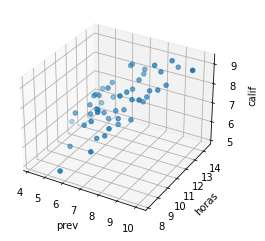

In [7]:
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

df = load_dataset().astype('float32')
ss = StandardScaler()
df_pp = copy.copy(df)
df_pp[['prev', 'horas']] = ss.fit_transform(df[['prev', 'horas']].to_numpy())
plot_3d(df)

# dataloaders
test_size = 0.2
train_ix = int(df_pp.shape[0] // (1 / (1 - test_size)))
train_TD = CustomCalifDataset(df_pp.iloc[:train_ix, :])
test_TD = CustomCalifDataset(df_pp.iloc[train_ix:, :])

trainloader = DataLoader(train_TD, batch_size=2, shuffle=True, num_workers=0)
testloader = DataLoader(test_TD, batch_size=2, shuffle=True, num_workers=0)

Partiendo de una configuración base de hyperparámetros, exploramos el impacto
de una variable en el desempeño de la red. Dada la naturaleza estocástica de las redes, para
cada configuración se realizan 5 repeticiones. Para la variable 'nodos por capa', no se puede
observar un patrón claro.

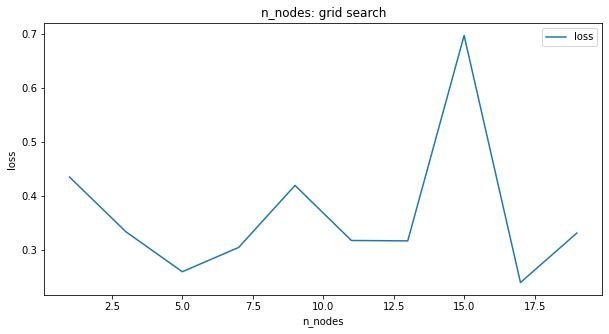

In [8]:
base_cfg = {'n_inputs': 2, 'n_hidden_layers': 1, 'n_nodes': 15, 'activation': 'sigmoid',
            'n_epochs': 15, 'learning_rate': 0.005}
n_repeats = 5
var_name, var_range = ('n_nodes', list(range(1, 20, 2)))
grid_search(var_name, var_range, base_cfg, n_repeats)


Si variamos el número de capas ocultas, vemos que los mejores resultados son con 1 o 2 capas ocultas.

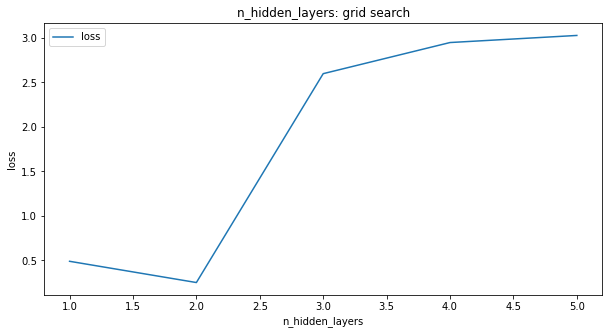

In [16]:
var_name, var_range = ('n_hidden_layers', np.arange(1, 6))
grid_search(var_name, var_range, base_cfg, n_repeats)


Comparamos ahora las tres funciones de activación y vemos que la mejor función es la 'tanh'.

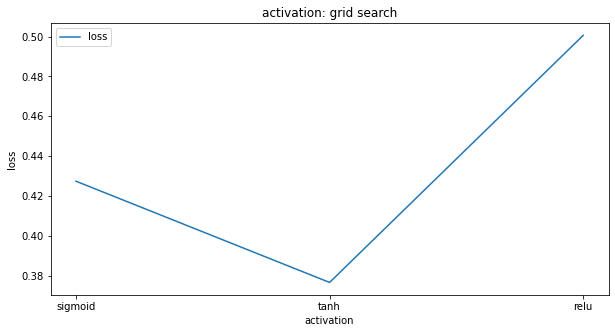

In [9]:
var_name, var_range = ('activation', ['sigmoid', 'tanh', 'relu'])
grid_search(var_name, var_range, base_cfg, n_repeats)


Comparando el número de épocas, después de 5 épocas no se presentan mejoras.

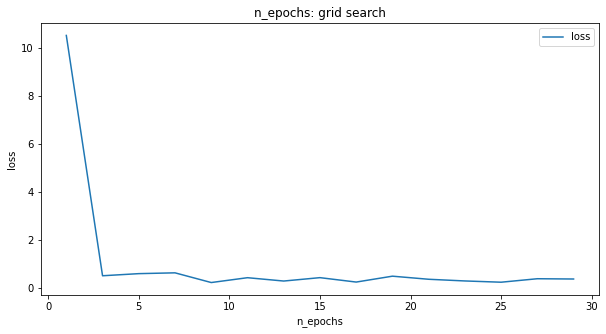

In [10]:
var_name, var_range = ('n_epochs', list(range(1, 30, 2)))
grid_search(var_name, var_range, base_cfg, n_repeats)


Por último usamos diferentes tasas de aprendizaje y observamos que los mejores resultados se presentan
cuando el l_r < 0.003

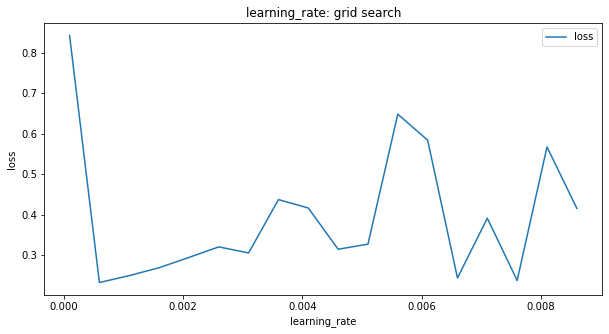

In [11]:
var_name, var_range = ('learning_rate', np.arange(0.0001, 0.01, 0.0005))
grid_search(var_name, var_range, base_cfg, n_repeats)


La predicción final la realizamos usando una función de activación 'tanh', 10 nodos por capa, 1 capa oculta
y una tasa de aprendizaje de 0.003.

 E00 loss=[  1.42,  2.92] 
 E01 loss=[  0.56,  1.62] 
 E02 loss=[  0.20,  0.12] 
 E03 loss=[  0.26,  0.16] 
 E04 loss=[  0.50,  0.49] 
 E05 loss=[  0.19,  0.18] 
 E06 loss=[  0.28,  0.18] 
 E07 loss=[  0.20,  0.38] 
 E08 loss=[  0.24,  0.11] 
 E09 loss=[  0.20,  0.21] 
Train Time: 0.082 s
Test Loss: 0.21 mse


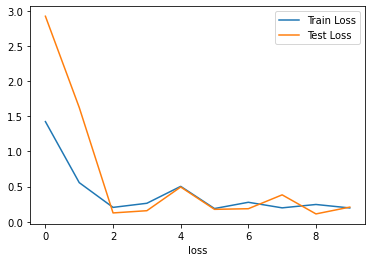

In [18]:
model_cfg = {'n_inputs': 2, 'n_hidden_layers': 1, 'n_nodes': 10, 'activation': 'tanh',
             'n_epochs': 10, 'learning_rate': 0.003}
model, loss_hist = train_test_model(model_cfg, plot_=True)

El modelo predice una calificación de 6.3 para un estudiante que estudió 12h y sacó 3 en su examen previo.
Notese que los datos deben normalizarse previamente.

In [15]:
input = np.array([3., 12.], dtype="float32").reshape(1, -1)
scaled_input = torch.tensor(ss.transform(input))
pred = model(scaled_input)
print('Calificación predicha: {:.2}'.format(pred.detach().numpy()[0][0]))

Calificación predicha: 6.3
